# ZFOURGE Observational Modelling and Fitting Analysis
This section is dedicated entirely to outputing the results from the ZFOURGE survey observational fitting, including creation of composite SED data. This involves some rudimentary fitting/analysis but nothing major. 

In [29]:
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import pandas as pd
import os
from astLib import astSED
import astropy.io.fits as fits
from carf import * # custom module for functions relating to the project
import matplotlib.path as mpath


# So that we can change the helper functions without reloading the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
# Choose if you want to save the plots
save_figures = False
fig_size_params = (10, 6)

In [31]:
# We would like to investigate the effects of the different filters.
# Read in the dataframe

field = 'COSMOS'
agn_model_name = 'Type1AGN'



# read in the dataframe and ensure that the unamed: 0 column is the index
composite_choice = f'{field}_obsevational_composites_fluxes{agn_model_name}'
composite_fluxes = pd.read_csv(f'outputs\composite_seds\{composite_choice}.csv', index_col=0)   
# Drop the first col
#composite_fluxes = composite_fluxes.drop(columns=['Unnamed: 0.1'])

composite_fluxes.reset_index(drop=True, inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: 'outputs\\composite_seds\\COSMOS_obsevational_composites_fluxesType2AGN.csv'

In [17]:
# Check outputs
composite_fluxes

# Check index column 
len(composite_fluxes.index.unique())

11846

In [18]:
composite_fluxes['id'].duplicated().sum()

# drop the duplicates
composite_fluxes = composite_fluxes.drop_duplicates(subset='id')


In [19]:
# have a look at it now
composite_fluxes


,id,z,U_0,U_10,U_20,U_30,U_40,U_50,U_60,U_70,...,r_10,r_20,r_30,r_40,r_50,r_60,r_70,r_80,r_90,r_100
0,CDFS_10003,1.6024,-18.897005,-18.897023,-18.897041,-18.897060,-18.897078,-18.897096,-18.897115,-18.897133,...,25.525865,25.525855,25.525845,25.525835,25.525825,25.525814,25.525804,25.525794,25.525784,NaN
1,CDFS_10004,0.1358,-22.502825,-22.502848,-22.502870,-22.502893,-22.502916,-22.502939,-22.502961,-22.502984,...,14.905498,14.905484,14.905470,14.905456,14.905441,14.905427,14.905413,14.905399,14.905384,NaN
2,CDFS_10005,1.7572,-20.506519,-20.506535,-20.506552,-20.506568,-20.506585,-20.506601,-20.506618,-20.506634,...,24.691450,24.691437,24.691424,24.691411,24.691397,24.691384,24.691371,24.691358,24.691345,NaN
3,CDFS_10008,3.0603,-19.406295,-19.406310,-19.406324,-19.406339,-19.406353,-19.406368,-19.406383,-19.406397,...,26.530743,26.530739,26.530735,26.530731,26.530727,26.530723,26.530720,26.530716,26.530712,NaN
4,CDFS_10010,3.2957,-18.350890,-18.350904,-18.350919,-18.350933,-18.350948,-18.350962,-18.350977,-18.350991,...,27.539007,27.539004,27.539001,27.538998,27.538996,27.538993,27.538990,27.538987,27.538984,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11841,CDFS_9983,1.8737,-18.980504,-18.980521,-18.980539,-18.980557,-18.980575,-18.980593,-18.980611,-18.980629,...,26.275389,26.275376,26.275364,26.275352,26.275340,26.275328,26.275316,26.275304,NaN,NaN
11842,CDFS_9988,0.6123,-22.762159,-22.762176,-22.762192,-22.762209,-22.762225,-22.762242,-22.762259,-22.762275,...,19.349518,19.349501,19.349485,19.349468,19.349452,19.349436,19.349419,19.349403,NaN,NaN
11843,CDFS_9994,1.9942,-20.057617,-20.057633,-20.057649,-20.057665,-20.057681,-20.057697,-20.057713,-20.057729,...,24.840954,24.840947,24.840941,24.840934,24.840928,24.840921,24.840915,24.840908,NaN,NaN
11844,CDFS_9995,4.6410,-17.787288,-17.787303,-17.787318,-17.787334,-17.787349,-17.787364,-17.787379,-17.787394,...,29.483466,29.483462,29.483457,29.483452,29.483447,29.483443,29.483438,29.483433,NaN,NaN


In [20]:
# Make some plots
# Plot the SEDs of the composite object
# Get the filters
filters = composite_fluxes.columns[2:]

# For the first filter, see how many variations there are
filter_choice = filters[0].split('_')[0]


# Get the variations
filter_variations = [filter for filter in filters if filter_choice in filter]

# add the alpha values to a new array
alpha_values = [int(filter.split('_')[1]) for filter in filter_variations]

# Print the alpha values
print(alpha_values)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [21]:
# Check the range of redshift values
composite_fluxes['z'].describe()


count    11846.000000
mean         1.686225
std          1.065076
min          0.102800
25%          0.797475
50%          1.435150
75%          2.361000
max          4.972600
Name: z, dtype: float64

## UVJ

redshift_bin:  [0, 0.5]


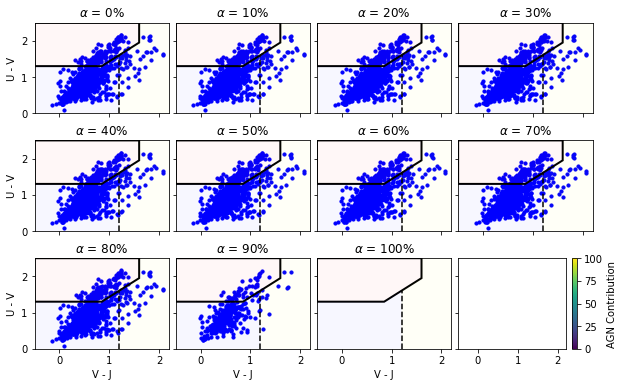

redshift_bin:  [0.5, 1]


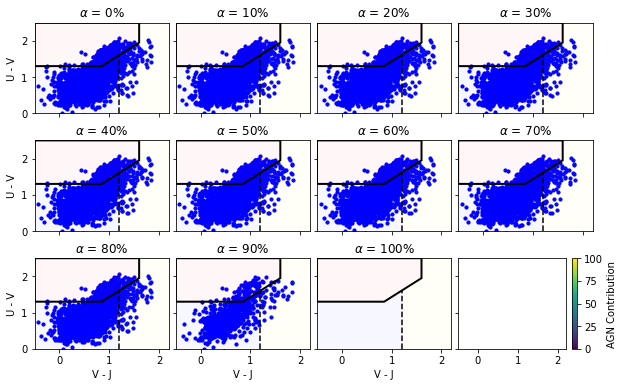

redshift_bin:  [1, 1.5]


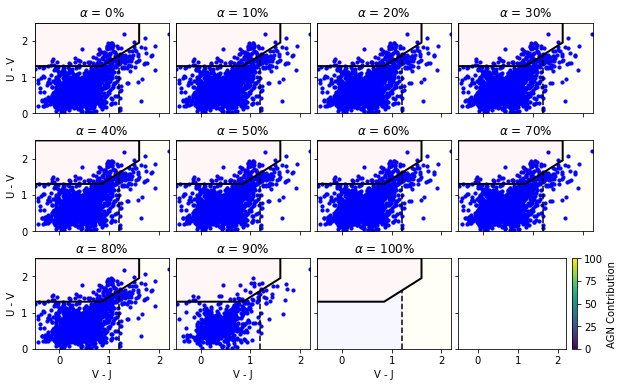

redshift_bin:  [1.5, 2]


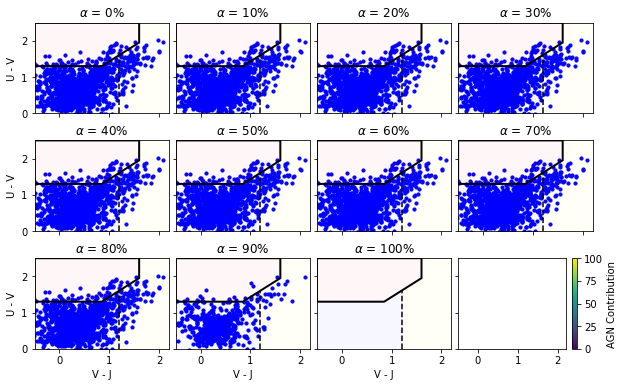

redshift_bin:  [2, 2.5]


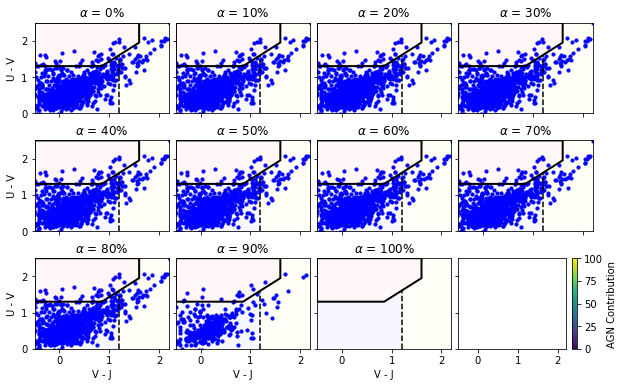

redshift_bin:  [2.5, 3]


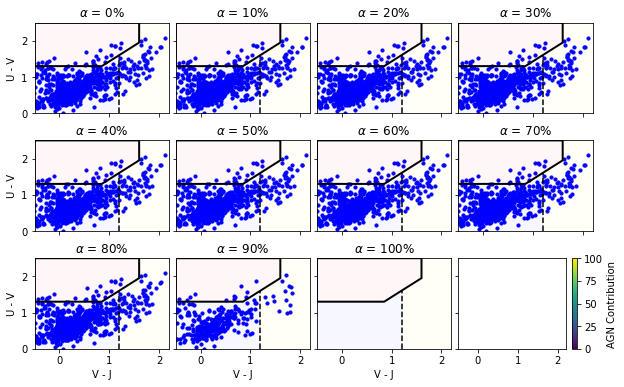

redshift_bin:  [3, 3.5]


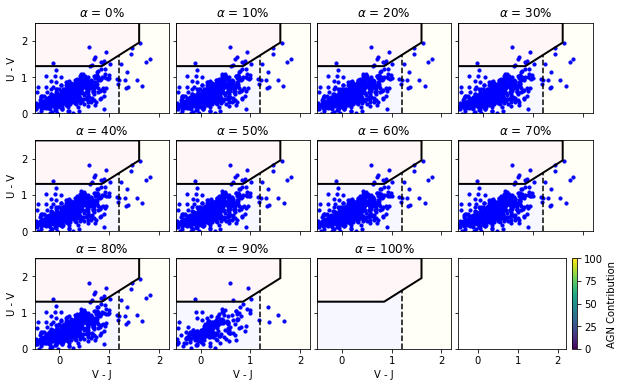

redshift_bin:  [3.5, 4]


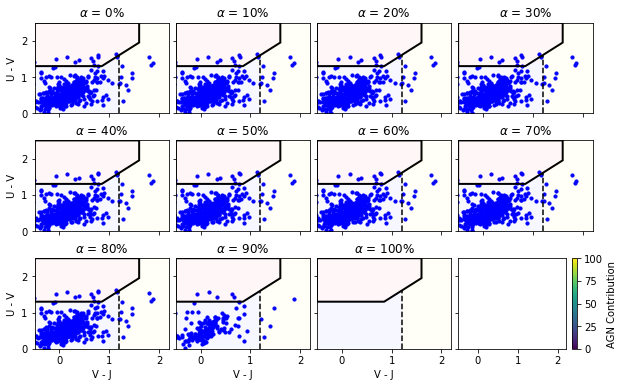

In [22]:
spacing = len(alpha_values)
colours_theme = plt.cm.viridis(np.linspace(0, 1, spacing))

# # Galaxy Fractions - Quiescent, Star-forming, Dusty for each alpha value
# galaxy_fractions = {'Star-forming': [], 'Quiescent': [], 'Dusty': []} # each key will have a list of fractions for each alpha value
# num_galaxies = len(composite_fluxes[composite_fluxes['z'] == 0]) # number of galaxies in the composite_flux in the rest frame


redshift_bins = [[0, 0.5], [0.5, 1], [1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3], [3, 3.5], [3.5, 4]]

for redshift_bin in redshift_bins:
    lower_redshift_limit = redshift_bin[0]
    upper_redshift_limit = redshift_bin[1]

    subset_composite_fluxes = composite_fluxes[(composite_fluxes['z'] >= lower_redshift_limit) & (composite_fluxes['z'] < upper_redshift_limit)].copy()

    print("redshift_bin: ", redshift_bin)


    fig, axs = plt.subplots(3, 4, figsize=fig_size_params, sharex=True, sharey=True)
    for n in range(len(alpha_values)):
        # Get the filter magnitudes
        U_mag = subset_composite_fluxes[f'U_{alpha_values[n]}']
        V_mag = subset_composite_fluxes[f'V_{alpha_values[n]}']
        J_mag = subset_composite_fluxes[f'J_{alpha_values[n]}']
        
        # Create the colours
        uv = U_mag - V_mag
        vj = V_mag - J_mag
        
        # If the uv, and vj values don't exsist in this redshift bin, skip this bin
        if len(uv) == 0:
            break
        
        
        axs[n//4, n%4].scatter(vj, uv, c='blue', s=10)
        
        axs[n//4, n%4].set_xlim(-0.5, 2.2)
        axs[n//4, n%4].set_ylim(0, 2.5)
        
        # Plot AGN Contribution in the title 
        # alpha needs to be the alpha symbol
        #alpha_symbol = r'$\alpha$'
        axs[n//4, n%4].set_title(rf'$\alpha$ = {alpha_values[n]}%')
        
        # Define paths for selections
        path_quiescent = [[-0.5, 1.3], [0.85, 1.3], [1.6, 1.95], [1.6, 2.5], [-0.5, 2.5]]
        path_sf = [[-0.5, 0.0], [-0.5, 1.3], [0.85, 1.3], [1.2, 1.60333], [1.2, 0.0]]
        path_sfd = [[1.2, 0.0], [1.2, 1.60333], [1.6, 1.95], [1.6, 2.5], [2.2, 2.5], [2.2, 0.0]]
        
        # Add patches for selections
        axs[n//4, n%4].add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
        axs[n//4, n%4].add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
        axs[n//4, n%4].add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))
        
        # Add vertical line
        axs[n//4, n%4].axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5)
        
        # Add axis labels
        if n//4 == 2:
            axs[n//4, n%4].set_xlabel("V - J")
        if n%4 == 0:
            axs[n//4, n%4].set_ylabel("U - V")
            
        
        # We will obtain the Star-forming, Quiescent, and Dusty Fractions for this particular alpha value     
        # Obtain the number of galaxies with sf region dictated by the sf path
        # Create Path objects from your path coordinates (do this once, outside the loop)
        path_quiescent_obj = mpath.Path(path_quiescent)
        path_sf_obj = mpath.Path(path_sf)
        path_sfd_obj = mpath.Path(path_sfd)

        # Create a DataFrame with just the uv and vj columns for easier selection
        uvj_data = pd.DataFrame({'vj': vj, 'uv': uv})

        # Perform the selection
        quiescent_seds = uvj_data[path_quiescent_obj.contains_points(uvj_data.values)]
        sf_seds = uvj_data[path_sf_obj.contains_points(uvj_data.values)]
        sfd_seds = uvj_data[path_sfd_obj.contains_points(uvj_data.values)]

    # Plot colorbar for AGN contribution
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alpha_values), vmax=max(alpha_values)))
    cbar = plt.colorbar(sm, ax=axs[2, 3])

    # Name the colorbar
    cbar.set_label('AGN Contribution')

        
    # Make the subplots closer together
    plt.subplots_adjust(wspace=0.05, hspace=0.3)
        

    # Save the output
    # if save_figures:
        # plt.savefig(f'outputs/ThesisPlots/UVJ_evolution_{agn_model_name}_{template_set_name}.png')

    # Show the output
    plt.show()


In [23]:
# Do the same as above but bin the redshifts


# ugr


count    11846.000000
mean         1.686225
std          1.065076
min          0.102800
25%          0.797475
50%          1.435150
75%          2.361000
max          4.972600
Name: z, dtype: float64


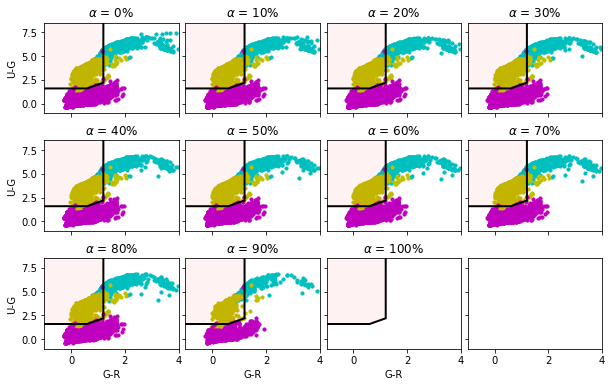

In [24]:
# ugr Diagram 
fig, axs = plt.subplots(3, 4, figsize=fig_size_params, sharex=True, sharey=True)

# have a look at the distibution for the composite_fluxes
print(composite_fluxes['z'].describe())


for n in range(len(alpha_values)):
    # Get the u, g, and r magnitudes for the specific alpha value
    u_col_name = f'u_{int(round(alpha_values[n], 2))}'
    g_col_name = f'g_{int(round(alpha_values[n], 2))}'
    r_col_name = f'r_{int(round(alpha_values[n], 2))}'
    
    # Create the colours for the UGR diagram
    ug_specific_alpha_colours = composite_fluxes[u_col_name] - composite_fluxes[g_col_name]
    gr_specific_alpha_colours = composite_fluxes[g_col_name] - composite_fluxes[r_col_name]

    # Scatter plots with color-coded redshift ranges
    axs[n // 4, n % 4].scatter(gr_specific_alpha_colours[composite_fluxes['z'] > 3.5], 
                               ug_specific_alpha_colours[composite_fluxes['z'] > 3.5], 
                               c="c", s=10, label="z > 3.5")

    axs[n // 4, n % 4].scatter(gr_specific_alpha_colours[(composite_fluxes['z'] > 2.6) & (composite_fluxes['z'] <= 3.5)], 
                               ug_specific_alpha_colours[(composite_fluxes['z'] > 2.6) & (composite_fluxes['z'] <= 3.5)], 
                               c="y", s=10, label="2.6 < z < 3.5")

    axs[n // 4, n % 4].scatter(gr_specific_alpha_colours[composite_fluxes['z'] < 2.6], 
                               ug_specific_alpha_colours[composite_fluxes['z'] < 2.6], 
                               c="m", s=10, label="z < 2.6")
    
    
    # Set the AGN Contribution title 
    axs[n//4, n%4].set_title(rf'$\alpha$ = {alpha_values[n]}%')
    
    plt.xlabel("")
    plt.ylabel("")
    #plt.title("UGR Diagram for SED Templates at Different Redshifts(0 < z < 4) for alpha = {}".format(alphas[n]))

      
    # Set the axis labels
    if n//4 == 2:
        axs[n//4, n%4].set_xlabel("G-R")
    if n%4 == 0:
        axs[n//4, n%4].set_ylabel("U-G")
    
    
    # add the alpha value information onto the plot somewhere
    #axs[n//4, n%4].text(0.5, 0.9, f"alpha = {round(alpha[n], 2)}", horizontalalignment='center', verticalalignment='center', transform=axs[n//4, n%4].transAxes)

    # Additionally we can plot the UGR selection criteria on the UGR diagram
    U_rule = [[1.2,9], [1.2,2.2], [0.6,1.6], [-3,1.6], [-3,9]]
    axs[n//4, n%4].add_patch(plt.Polygon(U_rule, closed=True, fill=True, facecolor=(1,0,0,0.05), edgecolor=(0,0,0,1), linewidth=2, linestyle='solid')) # This looks like the correct U dropout technique
    
    
    # The path here is the UGR selection criteria, we can find the selected points in this particular population using the path
    # Create Path objects from your path coordinates (do this once, outside the loop)
    path = mpath.Path(U_rule)
    
    # Create a DataFrame with just the u-g and g-r columns for easier selection
    ugr_data = pd.DataFrame({'gr': gr_specific_alpha_colours, 'ug': ug_specific_alpha_colours})
    
    # append the associated redshifts to the ugr data
    redshifts = composite_fluxes['z']
    
    axs[n//4, n%4].set_xlim(-1, 4)
    axs[n//4, n%4].set_ylim(-1, 8.5)
    
    
    # Make the subplots closer together
plt.subplots_adjust(wspace=0.05, hspace=0.3)
    

# if save_figures:
#     plt.savefig(f'outputs/ThesisPlots/ugr_evolution_{agn_model_name}_{template_set_name}.png')
    
# Plot
plt.show()

# As i don't have any extra redshift information this is accurately producing the right redshift information
# While there is limited redshift information, this does seem to be showing somewhat correct identification for low redshifts.

# IRAC 

<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
c:\Users\Mitchell\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


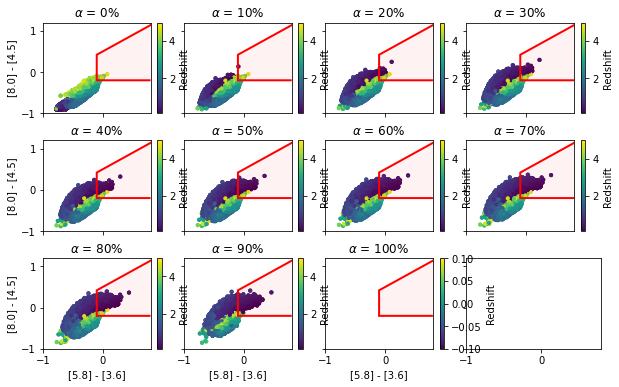

In [25]:
# Choose the diagram min and max
xmax = 0.8
ymax = 1.2
xmin = -1
ymin = -1

# Can change this to ensure we are only looking at the rest frame stuff
upper_redshift_limit = 0
lower_redshift_limit = 3.9

# setup 
fig, axs = plt.subplots(3, 4, figsize=fig_size_params, sharex=True, sharey=True)
for n in range(len(alpha_values)):
    
    # Get the IRAC magnitudes
    f_36 = composite_fluxes[f'IRAC3.6_{alpha_values[n]}']
    f_45 = composite_fluxes[f'IRAC4.5_{alpha_values[n]}']
    f_58 = composite_fluxes[f'IRAC5.8_{alpha_values[n]}']
    f_80 = composite_fluxes[f'IRAC8.0_{alpha_values[n]}']
    
    # Create the colours for the IRAC diagram
    f_5836_specific_alpha_colours = np.log10(f_58/f_36)
    f_8045_specific_alpha_colours = np.log10(f_80/f_45)

    # Redefine x and y for the first alpha value to plot the wedge
    x = f_5836_specific_alpha_colours
    y = f_8045_specific_alpha_colours
    
    
    
    # x = x[(composite_fluxes['z'] >= lower_redshift_limit) & (composite_fluxes['z'] <= upper_redshift_limit)]
    # y = y[(composite_fluxes['z'] >= lower_redshift_limit) & (composite_fluxes['z'] <= upper_redshift_limit)]
    
    
    
    # Reimplement the selection criteria 
    lacy_selection_condition = (x > -0.1) & (y > -0.2) & (y < 0.8 * x + 0.5)
    
    # Colour code for each alpha - colour by redshift
    axs[n//4, n%4].scatter(x, y, c=composite_fluxes['z'], cmap='viridis', s=10)
    
    # Put a colour bar on the plot
    cbar = plt.colorbar(axs[n//4, n%4].scatter(x, y, c=composite_fluxes['z'], cmap='viridis', s=10), ax=axs[n//4, n%4])
    cbar.set_label('Redshift')
    
    # axs[n//4, n%4].scatter(x[lacy_selection_condition], y[lacy_selection_condition], c='blue', s=10)
    # axs[n//4, n%4].scatter(x[~lacy_selection_condition], y[~lacy_selection_condition], c='grey', s=10)
    
    
    # Get the IRAC magnitudes
    f_36 = composite_fluxes[f'IRAC3.6_{alpha_values[0]}']
    f_45 = composite_fluxes[f'IRAC4.5_{alpha_values[0]}']
    f_58 = composite_fluxes[f'IRAC5.8_{alpha_values[0]}']
    f_80 = composite_fluxes[f'IRAC8.0_{alpha_values[0]}']
    
    # Create the colours for the IRAC diagram
    f_5836_specific_alpha_colours = np.log10(f_58/f_36)
    f_8045_specific_alpha_colours = np.log10(f_80/f_45)
    
    
    # Redefine x and y for the first alpha value to plot the wedge
    x = f_5836_specific_alpha_colours
    y = f_8045_specific_alpha_colours
    
    # # Ensure we are only looking at the rest frame stuff
    # x = x[composite_fluxes['z'] == 0]
    # y = y[composite_fluxes['z'] == 0]

    # # Reimplement the selection criteria
    lacy_selection_condition = (x > -0.1) & (y > -0.2) & (y < 0.8 * x + 0.5)
    wedge_vertices = [
        (xmax, -0.2),
        (-0.1, -0.2),
        (-0.1, 0.8*-0.1 + 0.5 ),  # Handle empty selection
        (((ymax-0.5)/0.8), ymax)
    ] 
    wedge_polygon = plt.Polygon(wedge_vertices, closed=False, edgecolor='r', facecolor=(1,0,0,0.05), linestyle='-', linewidth=2, label='Lacy Wedge')
    # Plot the polygon on the subplot
    axs[n//4, n%4].add_patch(wedge_polygon)
    
    
    # Set the AGN Contribution title
    axs[n//4, n%4].set_title(rf'$\alpha$ = {alpha_values[n]}%')
    
    # Set the axis labels
    if n//4 == 2:
        axs[n//4, n%4].set_xlabel("[5.8] - [3.6]")
    if n%4 == 0:
        axs[n//4, n%4].set_ylabel("[8.0] - [4.5]")
    
    # Set the axis limits
    axs[n//4, n%4].set_xlim(xmin, xmax)
    axs[n//4, n%4].set_ylim(ymin, ymax)
    
    
        
        
# Make the subplots closer together
plt.subplots_adjust(wspace=0.05, hspace=0.3)
    
# # Save the output
# if save_figures:
    
#     plt.savefig(f'outputs/ThesisPlots/IRAC_evolution_{agn_model_name}_{template_set_name}.png')
    
      
# Show the output
plt.show()

# These may not be appropriate for the redshifts that we are looking at, as we are looking at the rest frame values
# May have to look back at the drawing board and explore these in greater detail at a later date.

